In [39]:
%matplotlib inline
from helpers.gym_render import display_frames_as_gif
import matplotlib.pyplot as plt
import gym
from hyperdash import monitor_cell
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from hyperdash import monitor_cell


In [2]:
if torch.cuda.is_available():
    print("Cuda ready")
    
use_cuda = True
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

Cuda ready


In [3]:
import torch.utils.data as data_utils
import os

data_path = os.getcwd() + "/data/"
frames = np.load(data_path + "cartpole_frames.npy")

# def sliding_window(a, window=4, step_size=1):
#     '''
#     Input is list of `shape` np arrays of length N
#     Output is N - 4 x 4 x `shape`
#     '''
#     end = a.shape[0]
#     #return np.moveaxis(np.stack([a[i:end-window+i+1:step_size] for i in range(window)]), 0, -1)
#     # TimeDistributed looks at axis 1
#     return np.moveaxis(np.stack([a[i:end-window+i+1:step_size] for i in range(window)]), 0, 1)

# def eps_to_stacked_window(a, offset=False):
#     if offset:
#         return np.vstack([sliding_window(np.stack(x))[1:] for x in a])
#     else:
#         return np.vstack([sliding_window(np.stack(x))[:-1] for x in a])

# windowed_frames = np.expand_dims(eps_to_stacked_window(frames), -1)
# windowed_frames_next = np.expand_dims(eps_to_stacked_window(frames, offset=True), -1)
# # windowed_actions = eps_to_stacked_window(actions)
# assert windowed_frames_next.shape == windowed_frames.shape
# print(windowed_frames.shape)

# stk_frames = torch.from_numpy(windowed_frames)
   

In [31]:
f = frames.view()
frms = []
[[frms.append(frame) for frame in frs] for frs in f]
len(frms)
arr = np.array(frms)
stk_frames = torch.from_numpy(arr)

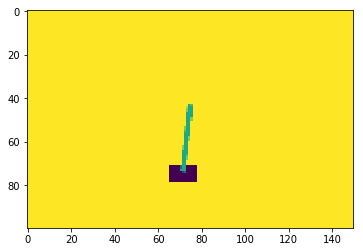

In [32]:
plt.imshow(arr[90])
plt.show()

In [33]:
z_dim = 30
X_dim = 150
N = 1000
train_batch_size = 2
valid_batch_size = 100
epochs = 100

In [34]:
train       = data_utils.TensorDataset(stk_frames.float(), stk_frames.float())
train_loader= data_utils.DataLoader(train, batch_size=train_batch_size)

In [35]:
#Encoder
class Q_net(nn.Module):  
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss

# Decoder
class P_net(nn.Module):  
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.25)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.25)
        x = self.lin3(x)
        return F.sigmoid(x)



In [36]:
torch.manual_seed(10)  
Q = Q_net()
P = P_net()     # Encoder/Decoder  
if use_cuda:  
    Q = Q.cuda()
    P = P.cuda()
# Set learning rates
gen_lr, reg_lr = 0.0006, 0.0008  
# Set optimizators
P_decoder = optim.Adam(P.parameters(), lr=gen_lr)  
Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)  
Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)  

In [37]:
model = Q_net()
if use_cuda:
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()


In [38]:
%%monitor_cell "Model-based cartpole"
x = Variable(torch.randn(N, 150)).type(FloatTensor)
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = Variable(data).type(FloatTensor), Variable(target).type(FloatTensor).detach()
        output = model(x)            
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(long(loss.data[0]))
#     for param in model.parameters():
#         print(param.var())
#         break


127
129
130
131
130
128
129
129
129
129


KeyboardInterrupt: 

[2017-08-24 16:13:35,242] Cell magic `%%notify` not found.
